In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix
import pickle

In [3]:
clients = pd.read_csv('churn.csv')
display(clients)

,ID,Age,Sexe,Durée d'abonnement (en mois),Nombre de lectures,Taux d'ouverture,Churn
0,1,32,M,6,10,0.75,Non
1,2,45,F,12,15,0.85,Non
2,3,28,M,3,5,0.60,Oui
3,4,50,F,8,12,0.70,Non
4,5,37,M,9,8,0.65,Non
...,...,...,...,...,...,...,...
322,323,53,F,4,6,0.55,Oui
323,324,29,M,2,4,0.40,Oui
324,325,44,F,10,18,0.90,Non
325,326,34,M,7,9,0.75,Non


In [4]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327 entries, 0 to 326
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   ID                            327 non-null    int64 
 1   Age                           327 non-null    object
 2   Sexe                          327 non-null    object
 3   Durée d'abonnement (en mois)  327 non-null    object
 4   Nombre de lectures            327 non-null    object
 5   Taux d'ouverture              327 non-null    object
 6   Churn                         327 non-null    object
dtypes: int64(1), object(6)
memory usage: 18.0+ KB


Les valeurs censées être numériques ne le sont. Je vais donc procéder à une conversion.

In [5]:
indices_erreurs = pd.to_numeric(clients['Age'], errors="coerce").isna()
display(clients[indices_erreurs])

,ID,Age,Sexe,Durée d'abonnement (en mois),Nombre de lectures,Taux d'ouverture,Churn
128,129,...,...,...,...,...,...
140,141,...,...,...,...,...,...


J'avais essayé de convertir d'abord mais je rencontrais une erreur "Enable to convert str". J'ai donc essayé de retrouvé les lignes qui comportaient des chaines de caractères.

In [6]:
clients = clients.drop(clients[indices_erreurs].index)

Après avoir supprimé les lignes inutiles, j'ai donc converties en numériques.

In [7]:
clients['Age'] = pd.to_numeric(clients['Age'])
clients["Durée d'abonnement (en mois)"] = pd.to_numeric(clients["Durée d'abonnement (en mois)"])
clients['Nombre de lectures'] = pd.to_numeric(clients['Nombre de lectures'])
clients["Taux d'ouverture"] = pd.to_numeric(clients["Taux d'ouverture"])

In [8]:
clients.describe()

,ID,Age,Durée d'abonnement (en mois),Nombre de lectures,Taux d'ouverture
count,325.000000,325.000000,325.000000,325.000000,325.000000
mean,164.178462,40.150769,6.895385,10.006154,0.693692
std,94.803625,8.378694,2.792430,4.264405,0.148534
min,1.000000,26.000000,2.000000,4.000000,0.350000
25%,82.000000,33.000000,5.000000,7.000000,0.600000
50%,165.000000,39.000000,7.000000,9.000000,0.700000
75%,246.000000,48.000000,9.000000,13.000000,0.800000
max,327.000000,55.000000,12.000000,20.000000,0.950000


Il n'y avait pas en tant que tel des valeurs abberrantes. Donc je suis passé à l'exploration des données avec les nuages de points. La variable cible est la colonne Churn que j'ai fait mettre en couleur à chaque fois.

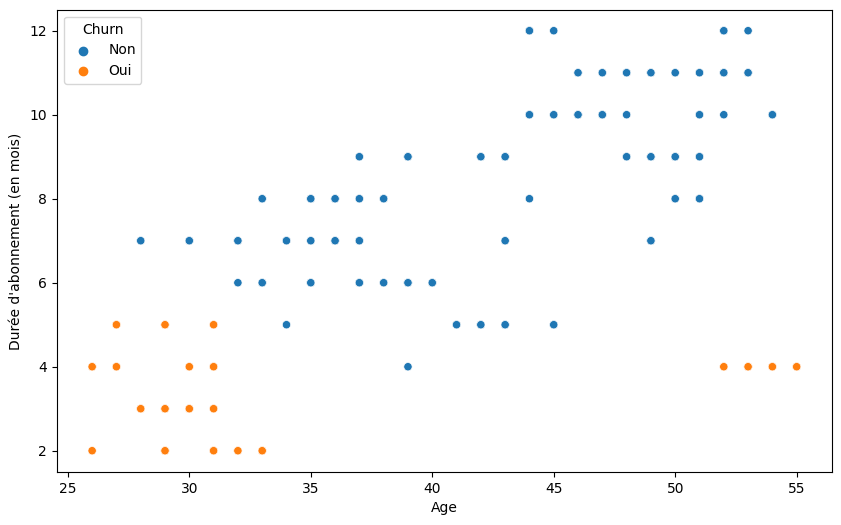

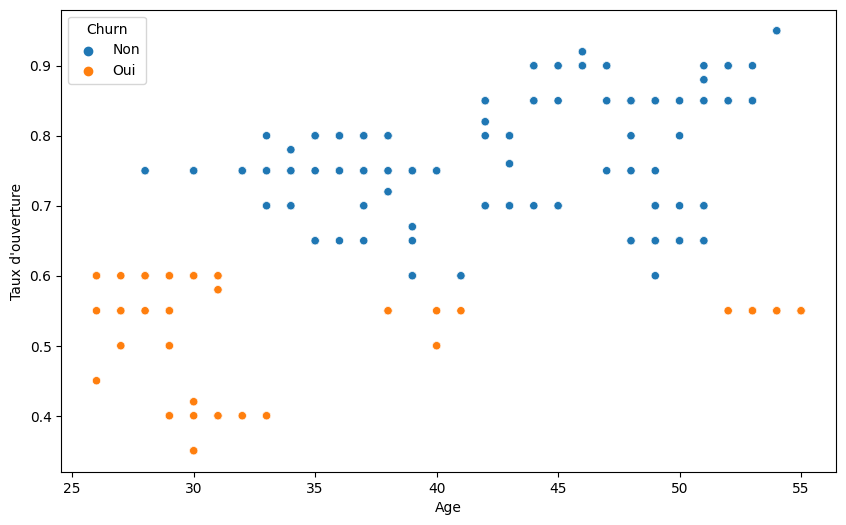

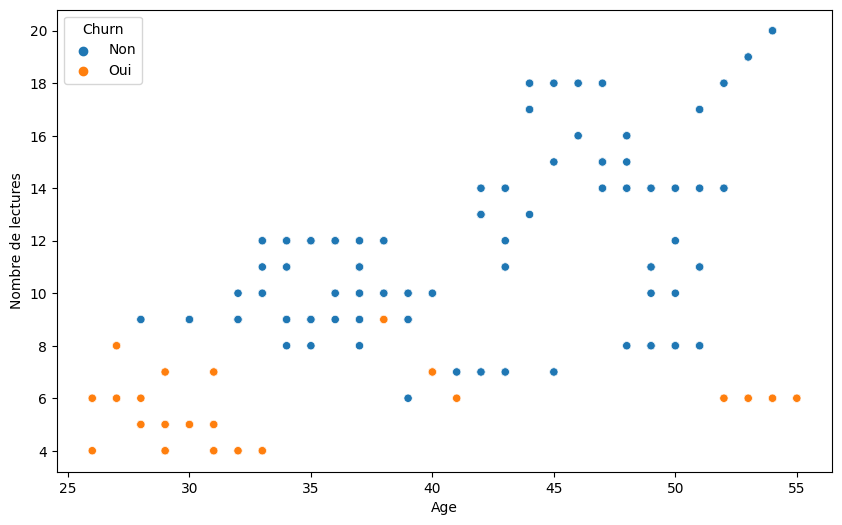

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=clients, x="Age", y="Durée d'abonnement (en mois)", hue="Churn")
plt.xlabel('Age')
plt.ylabel("Durée d'abonnement (en mois)")
plt.show()
plt.figure(figsize=(10, 6))
sns.scatterplot(data=clients, x="Age", y="Taux d'ouverture", hue="Churn")
plt.xlabel('Age')
plt.ylabel("Taux d'ouverture")
plt.show()
plt.figure(figsize=(10, 6))
sns.scatterplot(data=clients, x="Age", y="Nombre de lectures", hue="Churn")
plt.xlabel('Age')
plt.ylabel("Nombre de lectures")
plt.show()

Après les résultats des graphiques, j'ai estimé qu'il y avait une corrélation apparente entre la varible cible Churn et les variables (Durée d'abonnement, Taux d'ouverture, Nombre de lectures)

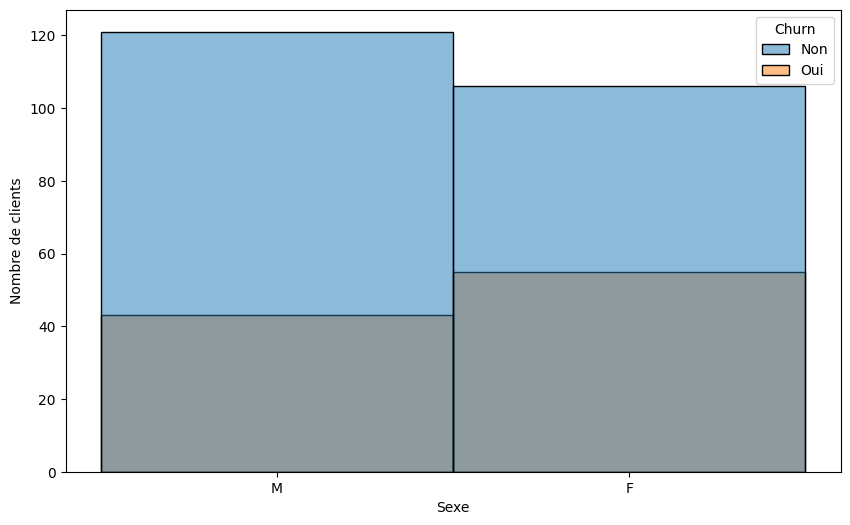

<Figure size 1000x600 with 0 Axes>

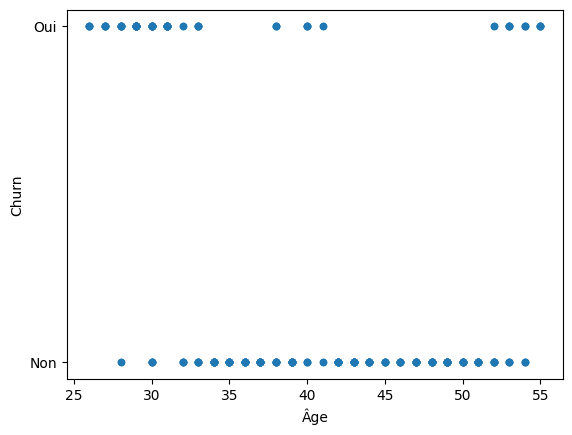

Churn,Non,Oui
Sexe,,
F,106,55
M,121,43


In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(data=clients, x="Sexe", hue="Churn")
plt.xlabel('Sexe')
plt.ylabel("Nombre de clients")
plt.show()
plt.figure(figsize=(10, 6))
clients.plot.scatter(x='Age', y='Churn')
plt.xlabel('Âge')
plt.ylabel('Churn')
plt.show()
pd.crosstab(clients['Sexe'], clients['Churn'])

Avec la variable Sexe, il n'y avait pas tellement de lien en apparence. Mais j'ai quand même décidé d'en tenir compte.

In [11]:
encoder = LabelEncoder()
for col in clients.select_dtypes(include='object').columns:
    clients[col] = encoder.fit_transform(clients[col])

pd.crosstab(clients['Sexe'], clients['Churn'])

Churn,0,1
Sexe,,
0,106,55
1,121,43


J'ai d'abord encodé les variables Sexe et Churn pour l'entrainement du modèle.

In [12]:
X = clients[['Age', 'Sexe', 'Durée d\'abonnement (en mois)', 'Nombre de lectures', 'Taux d\'ouverture']]
y = clients['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

J'ai créé ensuite le modèle et j'ai déterminer le score F1 et la matrice de confusion.

In [13]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

scoref1 = f1_score(y_test, y_pred)
print("F1-score :", scoref1)

cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :\n", cm)

F1-score : 0.975609756097561
Matrice de confusion :
 [[44  0]
 [ 1 20]]


A partir de ces résultats, on peut conclure que le score F1 proche de 1 indique une performance élevé du modèle.

*   44 clients ont été correctement classés comme "Non" (non résilié) et
*   20 clients ont été correctement classés comme "Oui" (résilié).
*   1 client a été classé comme "Oui" (résilié) alors qu'il aurait dû être classé comme "Non" (non résilié)
*   le 0 indique que tous les clients classés comme "Non" (non résilié) étaient effectivement non résiliés






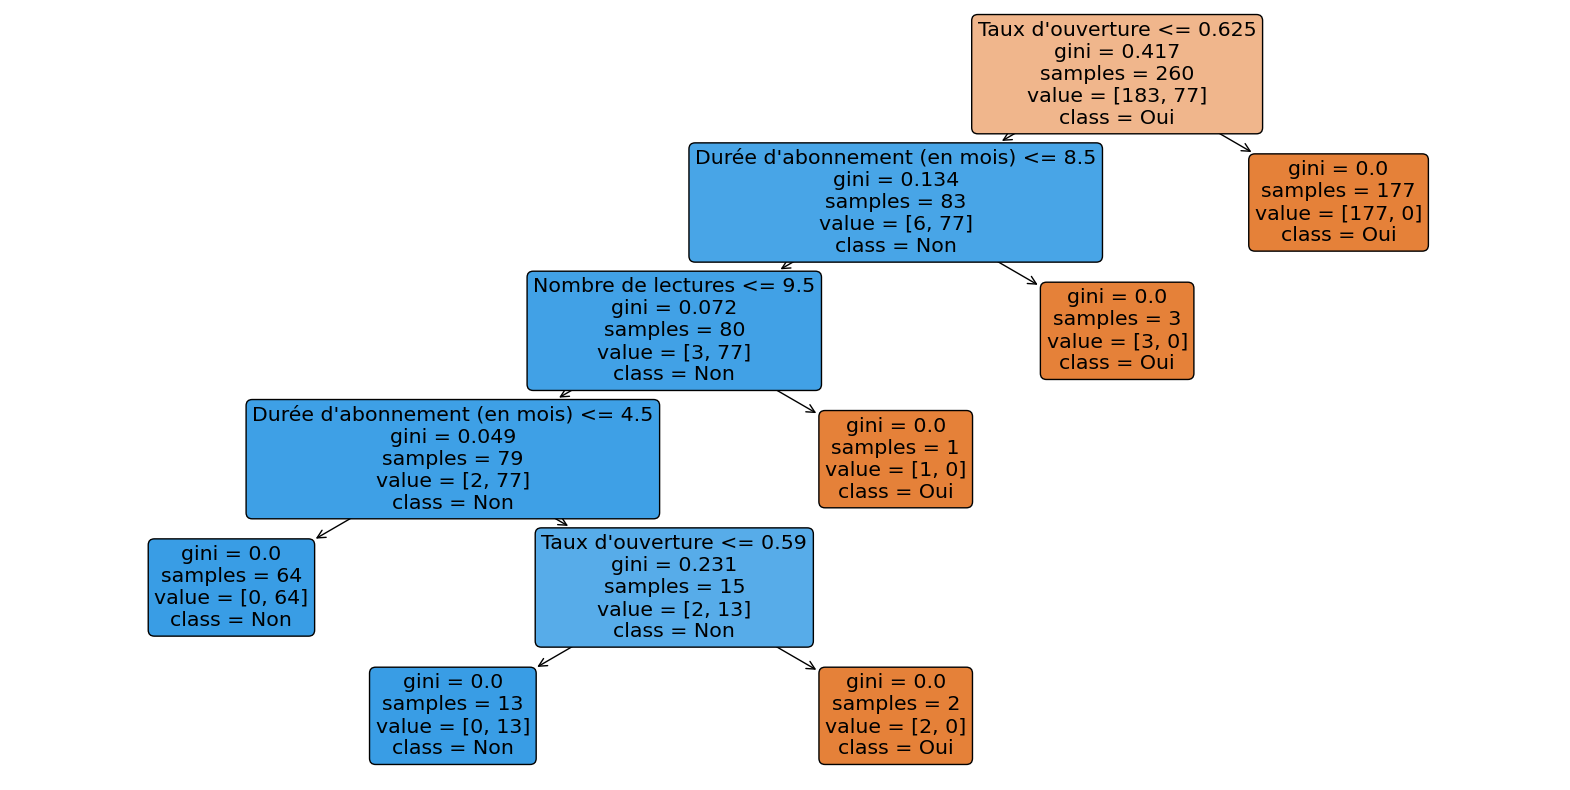

In [14]:
plt.figure(figsize=(20,10))
plot_tree(model, filled=True, rounded=True, feature_names=['Age', 'Sexe', 'Durée d\'abonnement (en mois)', 'Nombre de lectures', 'Taux d\'ouverture'], class_names=['Oui', 'Non'])
plt.show()

In [15]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)